<a href="https://colab.research.google.com/github/AntiPersnlMyne/RIT_CIS_ISAM/blob/main/RIT_ISAM_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install matplotlib
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib as mpl
import scipy
from scipy.fft import fft, fft2, ifft, ifft2, fftshift, ifftshift
import math

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part 1: Get the LSF

In [ ]:
# Call on chart
registered_iso_chart = cv.imread("/content/drive/Shareddrives/ISAM/Project3/registered_f22.png", cv.IMREAD_GRAYSCALE)
# Normalize image
print("Pre norm min", np.min(registered_iso_chart))
print("Pre norm max", np.max(registered_iso_chart))

# Normalize [0,1]
normalized_iso_chart = ((registered_iso_chart - registered_iso_chart.min()) \
           / (registered_iso_chart.max() - registered_iso_chart.min()))

# Validate
print("min", np.min(normalized_iso_chart))
print("max", np.max(normalized_iso_chart))

# Save
cv.imwrite("/content/drive/Shareddrives/ISAM/Project2/norm_22.png", normalized_iso_chart)

Pre norm min 62
Pre norm max 243
min 0.0
max 1.0


True

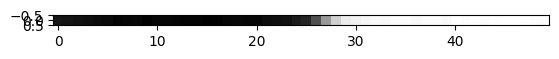

In [ ]:
# Get edge spread of slanted line
plt.imshow(normalized_iso_chart[120:121,520:570], cmap=mpl.colormaps["gray"])
# If we need to rerun, 5.6 is 525-575, other 2 are 520-570
edge_spread_func = normalized_iso_chart[120:121,520:570]

# Convert ESF to a vector
# Remove extra dimension (1,N) -> (N)
edge_spread_func = np.squeeze(edge_spread_func).astype(np.float64)

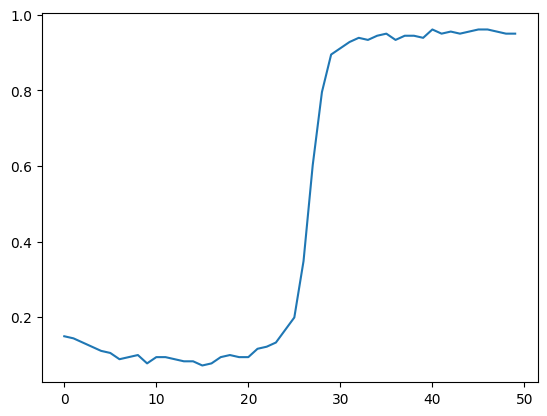

In [ ]:
plt.plot(edge_spread_func)

In [ ]:
# Differentiate ESF vector to estimate LSF
line_spread_func = np.gradient(edge_spread_func)

# Clip negative valued: [0,1]
dif_line_22 = line_spread_func.clip(0.0,1.0)

# Peak normalize
line_spread_func /= line_spread_func.max()

In [ ]:
# Initial guesses
amp = line_spread_func.max()                   # 1 after normalization
mu = np.argmax(line_spread_func)               # peak location
sigma = len(line_spread_func) / 10             # rough width guess
off = np.min(line_spread_func)                 # baseline

initial_guess = [amp, mu, sigma, off]


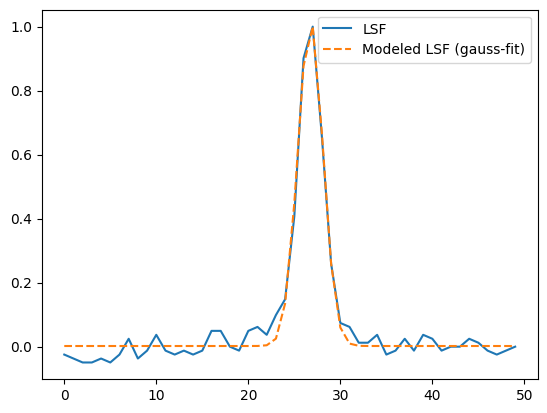

In [ ]:
# Define Gaussian function
def gaussian(x, amplitude, mean, stdev, offset):
  return amplitude * np.exp(-(x-mean)**2 / (2*stdev**2)) + offset

# x-data
x_axis = np.arange(len(line_spread_func))

# Fit Gaussian
parameters, _ = scipy.optimize.curve_fit(
    gaussian,
    xdata=x_axis,
    ydata=line_spread_func,
    p0=initial_guess, # initial curve params guess
)
fit_amplitude, fit_mean, fit_stdev, fit_offset = parameters
modeled_lsf = gaussian(x_axis, fit_amplitude, fit_mean, fit_stdev, fit_offset)

# Display curve-fit
plt.plot(line_spread_func)
plt.plot(modeled_lsf, linestyle="--")
plt.legend(["LSF", "Modeled LSF (gauss-fit)"])

### Part 2

Text(0, 0.5, 'modulation transfer')

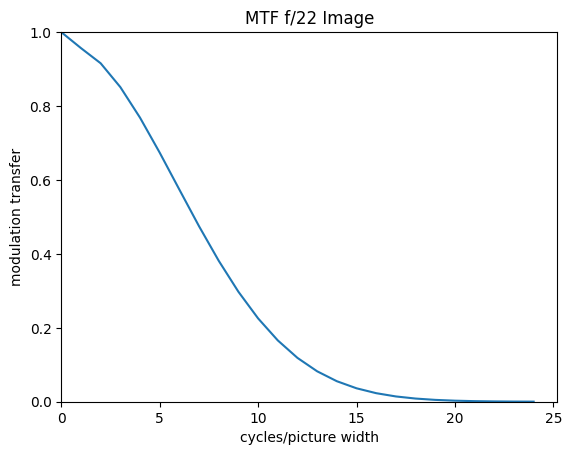

In [ ]:
# Calculate MTF from modeled LSF
mtf = fft(modeled_lsf)

# Zero-center MTF
mtf = fftshift(mtf)

# Magnitude of MTF
mtf_mag = np.abs(mtf)

# Peak normalize MTF
mtf_norm = mtf_mag/mtf_mag.max()

# Second half MTF vector
mtf_norm = mtf_norm[25:]

plt.plot(mtf_norm)
plt.title("MTF f/22 Image")
plt.ylim((0,1))
plt.xlim(left=0)
plt.xlabel("cycles/picture width")
plt.ylabel("modulation transfer")

### Part 3

In [ ]:
# Make the ideal step vector
step_func = np.zeros_like(mtf)
step_func[step_func.size//2:] = 1

# # Zero-center step function
# step_func = ifftshift(step_func)

Plot step

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Ideal Step Function')

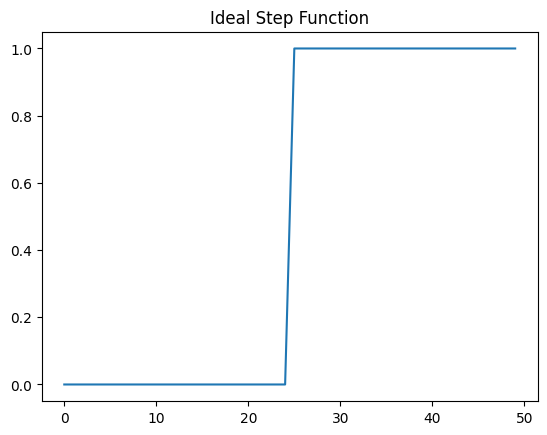

In [ ]:
plt.plot(step_func)
plt.title("Ideal Step Function")

In [ ]:
# Take the FT of the step vector
step_ft = fft(step_func)
# Zero-center the FFT
step_ft = fftshift(step_ft)

Plot step FT

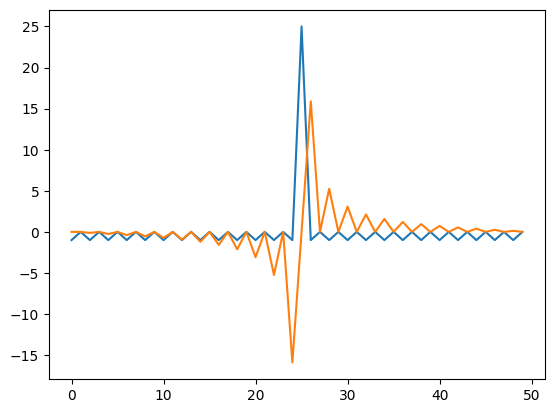

In [ ]:
plt.plot(step_ft.real)
plt.plot(step_ft.imag)

In [ ]:
# Rather than convolving in space, multiply in frequency
#  step    * PSF
#    |        |
# FT(step) x OTF
step_blur = step_ft*mtf

Plot blurred step function

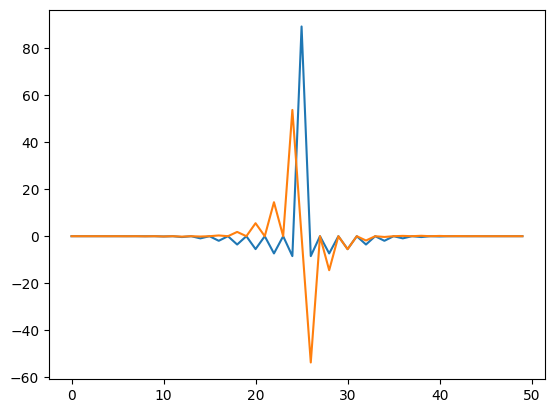

In [ ]:
plt.plot(step_blur.real)
plt.plot(step_blur.imag)

In [ ]:
# Invese FFT  (IFFT)
simulated_edge = ifft(ifftshift(step_blur))

# Normalize IFFT
simulated_edge_norm = simulated_edge/simulated_edge.max()
simulated_edge_norm = np.flip(simulated_edge_norm)

Text(0.5, 1.0, 'Measured vs. Simulated ESFs f/22 Image')

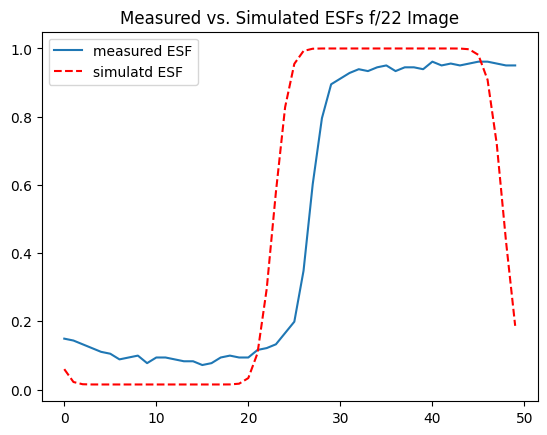

In [ ]:
# Plot both original ESF and simulated ESF
plt.plot(edge_spread_func)
plt.plot(simulated_edge_norm, linestyle="--", color="red")
plt.legend(["measured ESF", "simulatd ESF"])
plt.title("Measured vs. Simulated ESFs f/22 Image")

### Part 4

In [ ]:
# Load original 200 line ISO12233 chart
chart_path = r"/content/drive/Shareddrives/ISAM/Project3/ISO12233_chart_2000.tif"
chart_2000 = cv.imread(chart_path, cv.IMREAD_GRAYSCALE)

# Load scaled kernel PSF ; Proj2, step 6
kernel = np.load("/content/drive/Shareddrives/ISAM/Project3/kernel_but_for_real.npy")

In [ ]:
# Take FFT of chart image
chart_ft = fft2(chart_2000)
chart_ft = fftshift(chart_ft) # Zero-center FFT

Pad PSF kernel with zeros

In [ ]:
# Define padded region
kernel_padded = np.zeros_like(chart_2000, dtype=np.float32)

# Calculate the starting position to place the kernel
kernel_rows, kernel_cols = kernel.shape
pad_rows, pad_cols = kernel_padded.shape
start_row = (pad_rows - kernel_rows) // 2
start_col = (pad_cols - kernel_cols) // 2

# Place the kernel
kernel_padded[
    start_row:start_row + kernel_rows,
    start_col:start_col + kernel_cols
] = kernel / kernel.sum() # Normalize to preserve energy

# Check kernel and chart are equal sizes
assert chart_ft.shape == kernel_padded.shape, f"{chart_ft.shape} != {kernel.shape}"

In [ ]:
# Multiply the two transforms
simulated_camera_img = chart_ft * kernel_padded

In [ ]:
# Take FFT of padded kernel and zero-center it
kernel_ft = fft2(kernel_padded)
kernel_ft = fftshift(kernel_ft)

In [ ]:
# Multiply in frequency domain (complex multiplication)
filtered_ft = chart_ft * kernel_ft

In [ ]:
# Inverse FFT to get filtered image
filtered_ft = ifftshift(filtered_ft)  # Undo zero-centering before inverse FFT
simulated_camera_img = ifft2(filtered_ft)
simulated_camera_img = np.abs(simulated_camera_img)

In [ ]:
# Downsample the hi-res filtered image to match original image
simulated_camera_img = cv.resize(
    simulated_camera_img,
    registered_iso_chart.shape[::-1], # OpenCV expects reversed order
    interpolation=cv.INTER_NEAREST    # nearest neighbor
)

print(simulated_camera_img.shape)  # Should now be (561, 1058)
print(registered_iso_chart.shape)  # (561, 1058)

(561, 1058)
(561, 1058)


In [ ]:
# Shift image back to "normal"
simulated_camera_img = ifftshift(simulated_camera_img)

In [ ]:
# Assert filtered image is same size of original ISO12233 img
assert registered_iso_chart.shape == simulated_camera_img.shape, \
f"{registered_iso_chart.shape} != {simulated_camera_img.shape}"

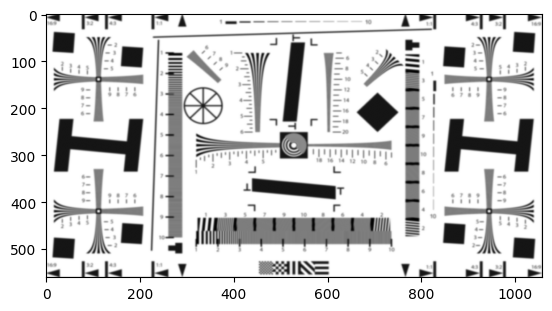

In [ ]:
plt.imshow(simulated_camera_img, cmap="gray")

Manual cropping for project writeup

In [ ]:
# Crop ranges
crop_row_start = 70
crop_row_end = 350
crop_col_start = 290
crop_col_end = 570

Text(0.5, 1.0, 'Simulated Camera Image at f/22')

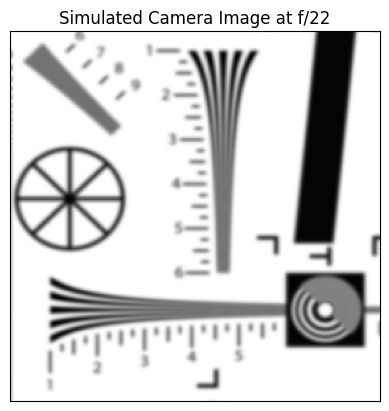

In [ ]:
plt.imshow(
    simulated_camera_img[crop_row_start:crop_row_end, crop_col_start:crop_col_end],
    cmap="gray"
)

# Disable ticks
plt.xticks([])
plt.yticks([])
plt.title("Simulated Camera Image at f/22")

Text(0.5, 1.0, 'Real Camera Image at f/22')

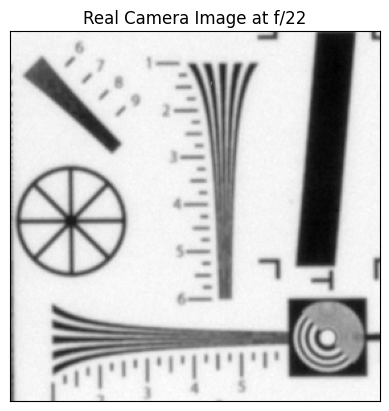

In [ ]:
plt.imshow(
    registered_iso_chart[crop_row_start:crop_row_end, crop_col_start:crop_col_end],
    cmap="gray"
)

# Disable ticks
plt.xticks([])
plt.yticks([])
plt.title("Real Camera Image at f/22")